## 1. Análisis Exploratorio de Datos (EDA) y Preprocesamiento del Texto Legal (NLP)

### 1.1. Importación de librerías y entorno de trabajo

En esta sección se importan todas las librerías necesarias para llevar a cabo un análisis completo de sentencias judiciales. Estas incluyen módulos para el preprocesamiento del lenguaje natural (NLP), visualización de datos, modelado estadístico y machine learning, modelado de temas (LDA), y representación vectorial del texto.

In [13]:
#### Instalación inicial

!pip install -q spacy nltk wordcloud pyLDAvis gensim
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.6 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [16]:
# ─── Manejo de datos ─────────────────────────────
import numpy as np
import pandas as pd

# ─── Visualización ───────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import IPython.display

# ─── Estadística ─────────────────────────────────
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import randint

# ─── NLP y preprocesamiento ──────────────────────
import re
import string
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Recursos NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Modelo SpaCy
nlp = spacy.load("en_core_web_sm")

# ─── Machine Learning ────────────────────────────
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
)
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, 
    roc_auc_score, roc_curve, accuracy_score, recall_score
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# ─── Topic Modeling y Embeddings ────────────────
from gensim.models import Word2Vec
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

# ─── Utilidades ──────────────────────────────────
import joblib
from operator import itemgetter
import networkx as nx

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nachodochao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nachodochao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nachodochao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
# Configuración de estilos generales de visualización

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

### 1.2. Carga de datos

En esta etapa se carga el archivo principal "dataset.csv" que contiene las sentencias judiciales australianas.

In [110]:
# Cargar el dataset
df = pd.read_csv('dataset.csv')  

### 1.3. Análisis Exploratorio de Datos (EDA)

En esta etapa se realiza una exploración general del dataset para identificar su calidad, consistencia y posibles problemas:

- Se ofrece una visión general del dataset
- Se verifican los valores nulos y duplicados.
- Se eliminan las filas sin texto (`case_text`) ya que son irrelevantes para el análisis de contenido.
- Se calcula la longitud media de los textos judiciales.
- Se revisan algunas muestras para entender el contenido.
- Se analiza la distribución de las categorías de `case_outcome`.

In [67]:
# 1. Información general
print("\n Información general del dataset:")
df.info()


 Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       24985 non-null  object
 1   case_outcome  24985 non-null  object
 2   case_title    24985 non-null  object
 3   case_text     24809 non-null  object
dtypes: object(4)
memory usage: 780.9+ KB


In [112]:
# Ver primeras filas
display(df.head(3))

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...


Se observa que el dataset contiene las siguientes columnas:

- `case_id`: identificador único de la sentencia.
- `case_outcome`: categoría del resultado judicial.
- `case_title`: título del caso.
- `case_text`: texto completo del fallo.

In [114]:
# Dimensiones
print("Dimensiones del dataset:", df.shape)

Dimensiones del dataset: (24985, 4)


In [69]:
# 2. Comprobación de nulos y duplicados
print("\n Valores nulos por columna:")
print(df.isnull().sum())

print("\n Número de filas duplicadas:", df.duplicated().sum())


 Valores nulos por columna:
case_id           0
case_outcome      0
case_title        0
case_text       176
dtype: int64

 Número de filas duplicadas: 0


In [71]:
# 3. Eliminación de filas con texto nulo
df_cleaned = df.dropna(subset=['case_text']).copy()
print("\n Revisión tras limpieza:")
print(df_cleaned.isnull().sum())


 Revisión tras limpieza:
case_id         0
case_outcome    0
case_title      0
case_text       0
dtype: int64


In [77]:
# 4. Análisis de longitud de textos
df_cleaned['text_length'] = df_cleaned['case_text'].apply(len)
print(f"\n Longitud promedio de los textos: {df_cleaned['text_length'].mean():.0f} caracteres")


 Longitud promedio de los textos: 2651 caracteres


In [79]:
# 5. Visualizar muestras aleatorias del texto
print("\n Muestras aleatorias del texto:")
print(df_cleaned['case_text'].sample(5, random_state=42))


 Muestras aleatorias del texto:
8093     agreed elements of the action for breach of co...
2459     The Episodes must be considered in their entir...
3260     The respondents argued that the concept of pro...
2874     Part 7 was inserted into the Native Title Act ...
18498    to the applicant's primary submission that pri...
Name: case_text, dtype: object



 Valores únicos en 'case_outcome':
['cited' 'applied' 'followed' 'referred to' 'related' 'considered'
 'discussed' 'distinguished' 'affirmed' 'approved']

 Frecuencia por categoría de outcome:
case_outcome
cited            12110
referred to       4363
applied           2438
followed          2252
considered        1699
discussed         1018
distinguished      603
related            112
approved           108
affirmed           106
Name: count, dtype: int64


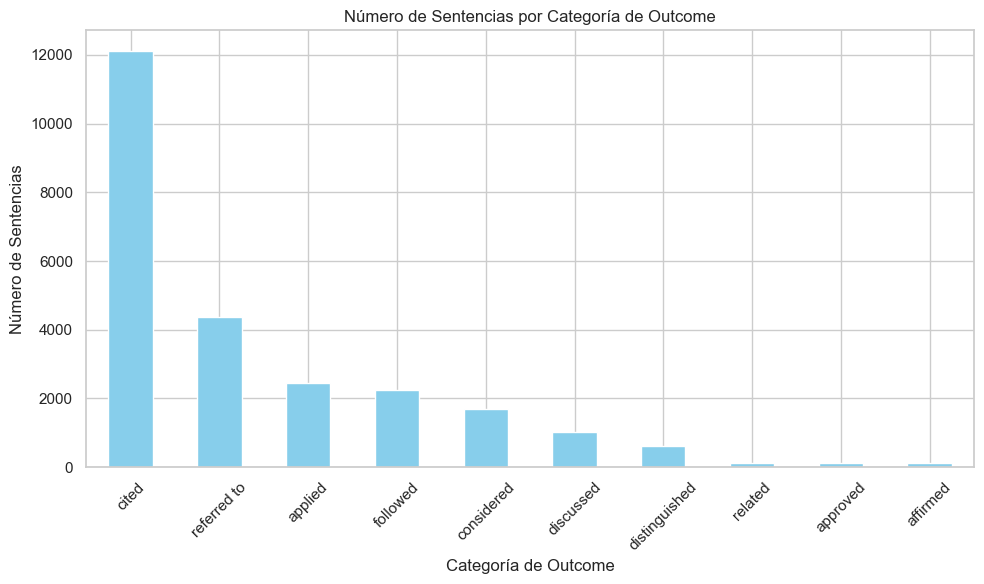

In [84]:
# 6. Distribución de clases en case_outcome
print("\n Valores únicos en 'case_outcome':")
print(df_cleaned['case_outcome'].unique())

outcome_counts = df_cleaned['case_outcome'].value_counts()
print("\n Frecuencia por categoría de outcome:")
print(outcome_counts)

# Gráfico de barras
plt.figure(figsize=(10, 6))
outcome_counts.plot(kind='bar', color='skyblue')
plt.title('Número de Sentencias por Categoría de Outcome')
plt.xlabel('Categoría de Outcome')
plt.ylabel('Número de Sentencias')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El gráfico anterior refleja la distribución de sentencias según la categoría case_outcome. Se observa un marcado desequilibrio de clases, donde la categoría *cited* domina ampliamente con más de 12.000 registros, seguida por *referred to*, mientras que otras como *approved*, *related* o *affirmed* presentan una representación residual.

Este desbalance severo tiene importantes implicaciones para el rendimiento de los modelos supervisados, ya que tenderán a favorecer las clases mayoritarias, penalizando significativamente la capacidad predictiva sobre clases minoritarias. Por ello, a lo largo del trabajo se han aplicado estrategias como:

- Ajuste de pesos (class_weight='balanced') en algoritmos clásicos.

- Evaluación con métricas como F1 macro, más adecuadas en contextos desbalanceados.

Estas decisiones metodológicas buscan mitigar el impacto del desequilibrio y garantizar resultados interpretables y comparables entre modelos.

### 1.4. Preprocesamiento del Texto Legal (NLP)

Se limpia el texto legal para prepararlo para los análisis posteriores. Este paso incluye:

- **Normalización**: elimina números, puntuación y emojis, y convierte a minúsculas.
- **Tokenización**: divide el texto en palabras individuales.
- **Lematización**: reduce cada palabra a su forma base utilizando `spaCy`.
- **Stopwords personalizadas**: se eliminan palabras irrelevantes generales y específicas del ámbito jurídico australiano que no aportan valor semántico.

Este proceso mejora significativamente los resultados en tareas de modelado de tópicos y clasificación.

In [100]:
# 1. Normalización del texto (eliminar puntuación, emojis, números, y pasar a minúsculas)
def normalize_text(text):
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    emoji_pattern = re.compile(
        "["u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"     # symbols & pictographs
        u"\U0001F680-\U0001F6FF"     # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"     # flags (iOS)
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001Faaa"
        u"\u200d"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub('', text)
    return text.lower()

df_cleaned = df_cleaned.drop_duplicates(subset=['case_text'])
df_cleaned['normalized_case_text'] = df_cleaned['case_text'].apply(normalize_text)

In [103]:
# 2. Tokenización
def tokenize_text(text):
    return word_tokenize(text, language='english')

df_cleaned['tokenized_case_text'] = df_cleaned['normalized_case_text'].apply(tokenize_text)

In [105]:
# 3. Lematización + eliminación de stopwords (NLTK + spaCy)
def lemmatize_then_filter(tokens):
    doc = nlp(' '.join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]

    stop_words = set(stopwords.words('english'))
    custom_stopwords = {
    'take', 'whether', 'make', 'case', 'court', 'tribunal', 'may', 'must',
    'not', 'will', 'shall', 'right', 'time', 'new', 'find', 'party', 'section',
    'document', 'claim', 'decision', 'any', 'reason', 'process', 'application',
    'applicant', 'order', 'say', 'provide', 'give', 'see', 'determine', 'refer',
    'first', 'consider', 'ground', 'respect', 'submit', 'power', 'act',
    'proceeding', 'proceed', 'proceedings', 'fca', 'hca', 'clr', 'fcr', 'cir',
    'pty', 'ltd', 'per', 'upon', 'one', 'amp', 'present', 'within',
    'include', 'point', 'particular', 'matter', 'fact', 'issue', 'question',
    'appellant', 'respondent', 'commission', 'commissioner',
    'judgment', 'review', 'appeal', 'minister', 'honour', 'member',
    'authority', 'state', 'federal', 'purpose', 'term', 'subject',
    'context', 'statement', 'provision', 'material', 'action', 'consideration',
    'use', 'set', 'note', 'follow', 'view', 'word', 'require', 'seek',
    'apply', 'hold', 'australia', 'australian', 'company', 'relevant', 'person',
    'relation', 'submission', 'notice', 'interest', 'exercise', 'want', 'account',
    'information', 'cost', 'opinion', 'support', 'establish', 'finding', 'way',
    'date', 'part', 'legal', 'counsel', 'circumstance', 'principle', 'basis', 'full',
    'rule', 'effect', 'grant', 'appropriate', 'good', 'might', 'far', 'regard', 'accept',
    'concern', 'result', 'necessary', 'involve', 'agree', 'show', 'mean', 'clear', 'write',
    'know', 'express', 'conclusion', 'cause', 'relate', 'amount', 'even', 'true', 'prior',
    'form', 'early', 'event', 'although', 'position', 'well', 'sense', 'address', 'file',
    'without', 'continue', 'base', 'rely', 'arise', 'mark', 'general', 'different', 'public',
    'describe', 'appear', 'bring', 'second', 'rather', 'lead', 'example', 'policy',
    'obtain', 'number', 'put', 'day', 'extent', 'place', 'test', 'adopt', 'fail', 'receive',
    'satisfied', 'entitle', 'two', 'high', 'common', 'according', 'meaning', 'period',
    'year', 'record', 'discuss', 'suggest', 'offer', 'approach', 'requirement', 'available',
    'produce', 'remain', 'need', 'understand', 'reach', 'hear', 'indicate', 'mind',
    'kind', 'certain', 'least', 'allow', 'whole', 'open', 'opportunity', 'absence', 'reasonable',
    'reference', 'report', 'advise', 'advice', 'observe', 'practice', 'draw', 'step', 'think', 'conclude',
    'thus', 'either', 'exist', 'serve', 'occur', 'correct', 'carry', 'explain', 'copy', 'limited', 'course',
    'paragraph', 'deal', 'affidavit', 'identify', 'third', 'income', 'condition', 'raise', 'work', 'design',
    'award', 'propose', 'transaction', 'existence', 'engage', 'seem', 'likely', 'proper', 'permit',
    'capital', 'benefit', 'client', 'letter', 'activity', 'would', 'also', 'however', 'could', 'alr',
    'fcafc', 'group', 'solicitor', 'service', 'commonwealth', 'relief', 'penalty', 'obligation', 'pay', 'cth', 'plaintiff',
    'truth', 'reasoning', 'value', 'situation', 'while', 'most', 'thing', 'false',
    'contract', 'agreement', 'business', 'taxation', 'corporation', 'creditor', 'trustee', 'bankruptcy',
        'url', 'httpwwwaustliieduauaucasescthfcahtml', 'mchugh',  'gummow'
}
    stop_words.update(custom_stopwords)

    return [
        lemma for lemma in lemmatized_tokens
        if lemma not in stop_words and len(lemma) > 2 and lemma not in string.punctuation
    ]

df_cleaned['final_tokens'] = df_cleaned['tokenized_case_text'].apply(lemmatize_then_filter)

## 2. Representación y análisis semántico del texto

### 2.1. Visualización Semántica (WordCloud y TF-IDF)

En esta sección se exploran y visualizan los patrones léxicos más frecuentes y significativos del corpus legal tras el preprocesamiento.

- **WordCloud**: Representación visual que destaca las palabras más comunes proporcional a su frecuencia.
- **TF-IDF**: Se calcula el puntaje TF-IDF para unigramas, bigramas y trigramas, identificando las combinaciones de términos más relevantes y distintivas. Se representan gráficamente los 30 términos con mayor peso para cada caso.

Esto permite identificar estructuras y expresiones jurídicas relevantes que pueden ser utilizadas en modelos posteriores o análisis cualitativos.

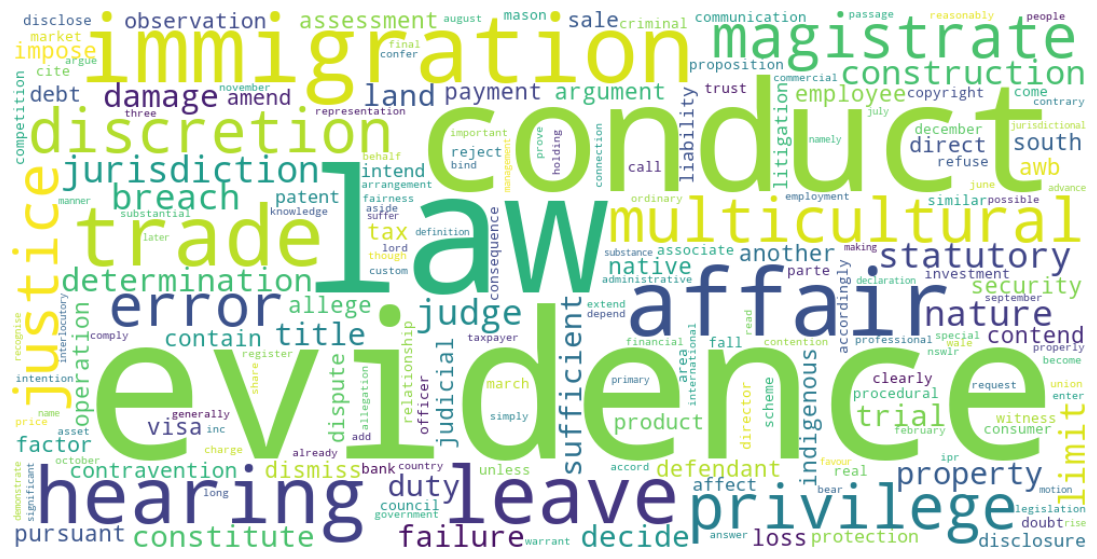

In [130]:
# === WordCloud ===
all_words = ' '.join([' '.join(tokens) for tokens in df_cleaned['final_tokens']])

wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    collocations=False
).generate(all_words)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Top 10 palabras por TF-IDF:
evidence: 411.3670
immigration: 364.1629
law: 321.2586
affair: 282.3074
multicultural: 276.3378
conduct: 274.3054
magistrate: 229.4689
error: 207.6223
leave: 200.0046
discretion: 191.3687


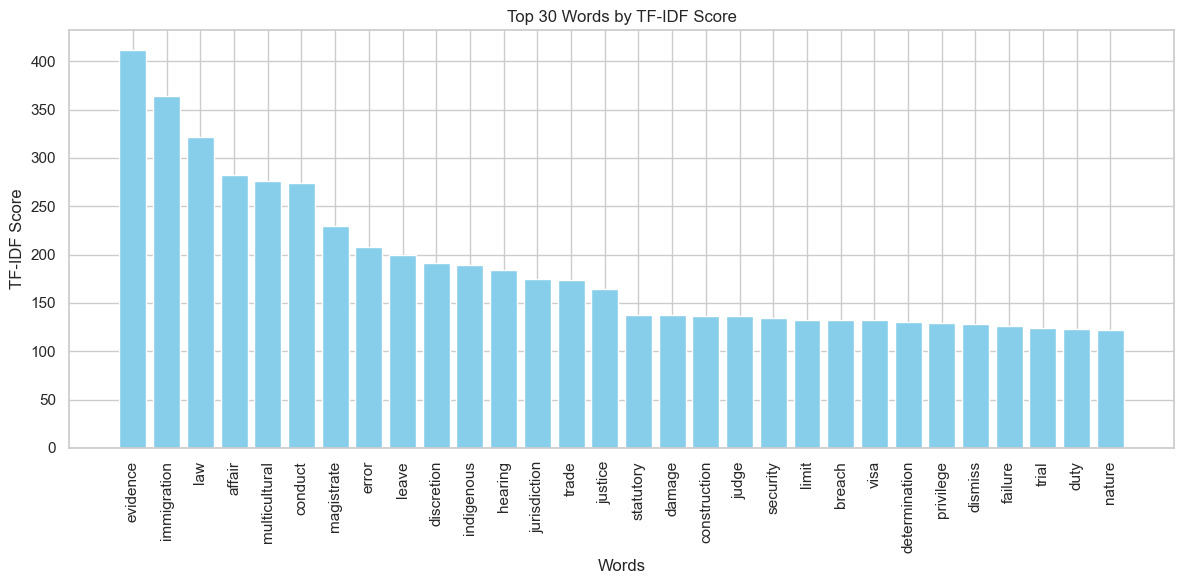

In [134]:
# === TF-IDF Unigramas ===
documents = [' '.join(tokens) for tokens in df_cleaned['final_tokens']]
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1
tfidf_dict = dict(zip(feature_names, tfidf_scores))

# Mostrar top 10 palabras por TF-IDF
print("Top 10 palabras por TF-IDF:")
top_10 = sorted(tfidf_dict.items(), key=itemgetter(1), reverse=True)[:10]
for word, score in top_10:
    print(f"{word}: {score:.4f}")

# Top 30 visualización
top_30 = top_10 + sorted(tfidf_dict.items(), key=itemgetter(1), reverse=True)[10:30]
words, scores = zip(*top_30)

plt.figure(figsize=(12, 6))
plt.bar(words, scores, color='skyblue')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.title('Top 30 Words by TF-IDF Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

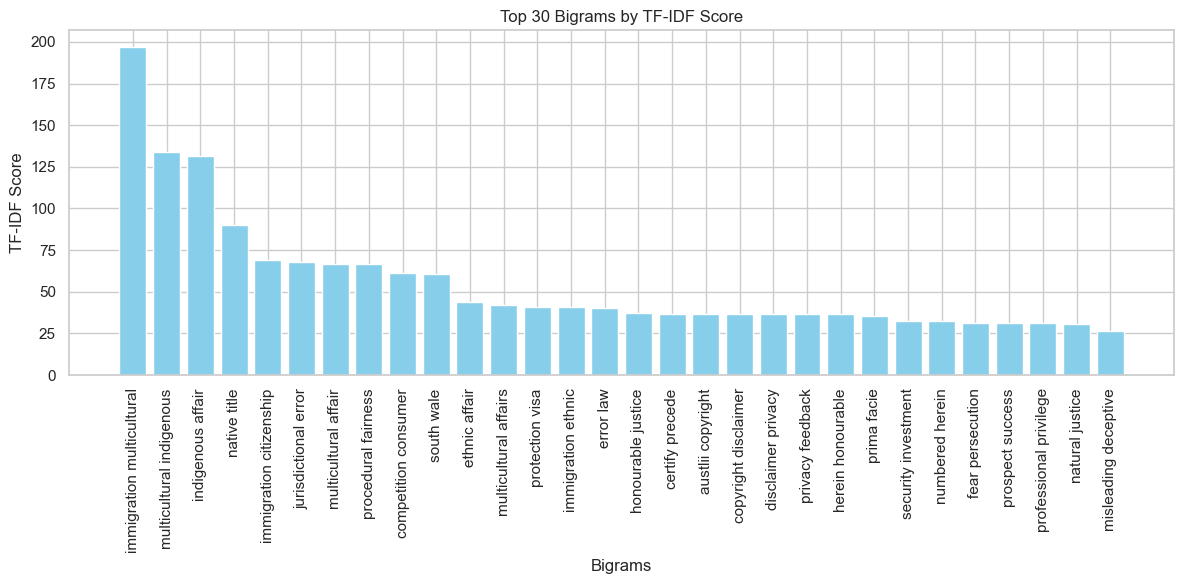

In [136]:
# === TF-IDF Bigramas ===
tfidf_vectorizer_bi = TfidfVectorizer(use_idf=True, ngram_range=(2, 2))
tfidf_matrix_bi = tfidf_vectorizer_bi.fit_transform(documents)
feature_names_bi = tfidf_vectorizer_bi.get_feature_names_out()
tfidf_scores_bi = tfidf_matrix_bi.sum(axis=0).A1
tfidf_dict_bi = dict(zip(feature_names_bi, tfidf_scores_bi))

# Top 30 bigramas
top_30_bi = sorted(tfidf_dict_bi.items(), key=itemgetter(1), reverse=True)[:30]
bigrams, scores = zip(*top_30_bi)

plt.figure(figsize=(12, 6))
plt.bar(bigrams, scores, color='skyblue')
plt.xlabel('Bigrams')
plt.ylabel('TF-IDF Score')
plt.title('Top 30 Bigrams by TF-IDF Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

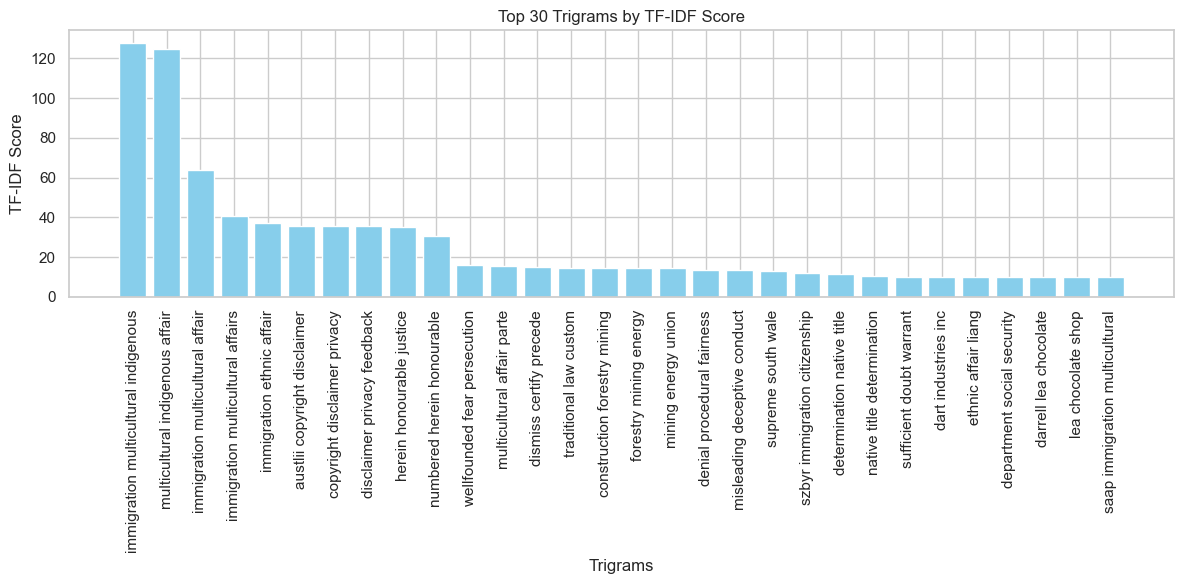

In [138]:
# === TF-IDF Trigramas ===
tfidf_vectorizer_tri = TfidfVectorizer(use_idf=True, ngram_range=(3, 3))
tfidf_matrix_tri = tfidf_vectorizer_tri.fit_transform(documents)
feature_names_tri = tfidf_vectorizer_tri.get_feature_names_out()
tfidf_scores_tri = tfidf_matrix_tri.sum(axis=0).A1
tfidf_dict_tri = dict(zip(feature_names_tri, tfidf_scores_tri))

# Top 30 trigrams
top_30_tri = sorted(tfidf_dict_tri.items(), key=itemgetter(1), reverse=True)[:30]
trigrams, scores_tri = zip(*top_30_tri)

plt.figure(figsize=(12, 6))
plt.bar(trigrams, scores_tri, color='skyblue')
plt.xlabel('Trigrams')
plt.ylabel('TF-IDF Score')
plt.title('Top 30 Trigrams by TF-IDF Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 2.2. Representación Numérica del Texto (Word Embeddings) 

En esta sección se entrena un modelo Word2Vec utilizando las sentencias judiciales previamente tokenizadas y lematizadas.

- **Word2Vec** transforma cada palabra en un vector denso de valores numéricos, capturando relaciones semánticas y sintácticas.
- Se entrena usando el enfoque **Skip-Gram**, que aprende a predecir el contexto de una palabra.
- La representación se entrena directamente sobre el lenguaje jurídico, permitiendo construir vectores semánticos personalizados adaptados al dominio legal.

Se comprueba el funcionamiento del modelo listando las palabras más similares a `'immigration'`, evaluando así su capacidad para capturar significados legales contextuales.

In [148]:
# Entrenar modelo Word2Vec con las sentencias tokenizadas
model_w2v = Word2Vec(
    sentences=df_cleaned['final_tokens'],  # lista de listas de tokens
    vector_size=100,       # dimensión de los vectores
    window=5,              # contexto de palabras
    min_count=5,           # mínimo número de apariciones
    workers=4,             # núcleos de CPU a usar
    sg=1,                  # 1 = skip-gram, 0 = CBOW
    seed=15
)

# Verificar palabras similares a 'immigration'
print(model_w2v.wv.most_similar('immigration', topn=10))

[('multicultural', 0.9258658289909363), ('indigenous', 0.8089767694473267), ('affair', 0.8063673377037048), ('citizenship', 0.7970594763755798), ('affairs', 0.7909491062164307), ('mima', 0.7666862607002258), ('szbaz', 0.7542721033096313), ('szcij', 0.7444915771484375), ('zhan', 0.743471622467041), ('wajr', 0.741710364818573)]


 ### 2.3. Modelado Temático

#### 2.3.1. Modelado Temático con LDA (Latent Dirichlet Allocation)

Esta sección aplica **LDA**, una técnica de modelado de temas que identifica patrones latentes en el corpus legal:

- Se construye un corpus en formato **Bag-of-Words (BoW)** a partir de los tokens lematizados.
- Se entrena el modelo LDA con distintos números de temas (`num_topics`).
- Para cada modelo, se calcula su **coherencia semántica**, una métrica que evalúa la interpretabilidad de los temas.
- Se visualiza la evolución del **Coherence Score** en función del número de temas, ayudando a seleccionar el número óptimo.

Este análisis temático permite descubrir agrupaciones temáticas comunes en sentencias judiciales, facilitando su interpretación y exploración.

Evaluando 2 temas...
Evaluando 3 temas...
Evaluando 4 temas...
Evaluando 5 temas...
Evaluando 6 temas...
Evaluando 7 temas...
Evaluando 8 temas...
Evaluando 9 temas...


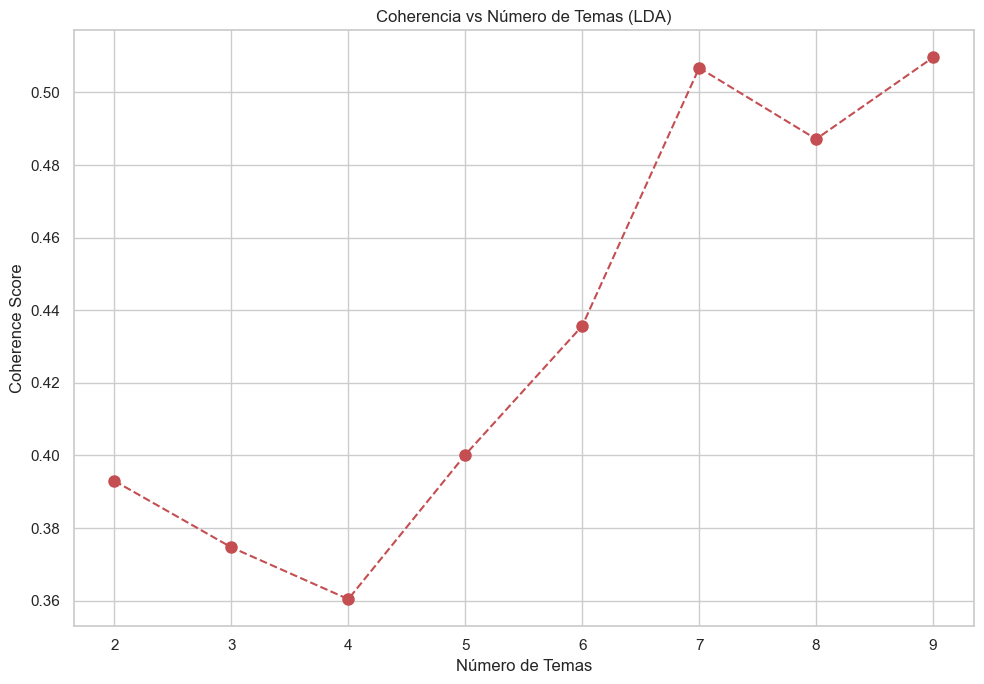

In [160]:
# Crear diccionario e instancias del corpus BoW
id2word = corpora.Dictionary(df_cleaned['final_tokens'])
corpus = [id2word.doc2bow(tokens) for tokens in df_cleaned['final_tokens']]

# Función para evaluar coherencia en diferentes números de temas
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_scores = []
    model_list = []

    for num_topics in range(start, limit, step):
        print(f"Evaluando {num_topics} temas...")

        model = LdaMulticore(
            corpus=corpus,
            num_topics=num_topics,
            id2word=dictionary,
            passes=15,
            iterations=100,
            chunksize=2000,
            eval_every=None,
            random_state=15
        )

        model_list.append(model)

        coherence_model = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )

        coherence_scores.append(coherence_model.get_coherence())

    return model_list, coherence_scores

# Ejecutar la búsqueda de número óptimo de temas
model_list_topic, coherence_values_topic = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus,
    texts=df_cleaned['final_tokens'],
    start=2,
    limit=10,
    step=1
)

# Visualización del score de coherencia
plt.figure(figsize=(10, 7))
plt.plot(range(2, 10), coherence_values_topic, '--r', marker='o', markersize=8)
plt.xlabel('Número de Temas')
plt.ylabel('Coherence Score')
plt.title('Coherencia vs Número de Temas (LDA)')
plt.grid(True)
plt.tight_layout()
plt.show()

Este gráfico representa la coherencia del modelo LDA en función del número de temas, la decisión óptima se toma buscando el punto donde el Coherence Score:

- Es alto

- No mejora significativamente con más temas (principio del codo / elbow)

La coherencia sube consistentemente de 4 a 7 temas. En 7 temas, alcanza un pico claro (≈ 0.51). Con 8 baja ligeramente, y en 9 sube apenas un poco más.

Por este motivo, voy a elegir 7 temas ya que:
1. Mayor coherencia clara sin sobreajustar:
    * 7 es el primer valor con una mejora fuerte y estable.
    * Pasar a 9 temas da una mejora mínima, lo cual podría no justificar la complejidad extra.
2. Principio del codo:
    * El “elbow” está justo entre 6 y 7 → el punto donde la pendiente empieza a aplanarse.
    * A partir de ahí, hay rendimientos decrecientes.
3. Menor riesgo de sobreajuste / fragmentación:
    * Con más temas, puedes acabar con tópicos muy similares o redundantes.


#### 2.3.2. Modelado LDA: Exploración de Temas

Se entrena el modelo LDA definitivo con el número óptimo de temas (`k=7`) según el valor máximo de coherencia observado.

- Se imprimen los temas extraídos (palabras más representativas por tema).
- Se limpia la salida de Gensim para visualizar los tópicos de forma más legible.

In [177]:
# Número óptimo de temas
k = 7

# Entrenar modelo LDA final
model_k = LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=k,
    passes=15,
    random_state=15
)

# Calcular coherencia
coherence_model_k = CoherenceModel(
    model=model_k,
    texts=df_cleaned['final_tokens'],
    dictionary=id2word,
    coherence='c_v'
)
coherence_score = coherence_model_k.get_coherence()
print(f"\n Coherence Score (k={k}): {coherence_score:.4f}\n")

# Mostrar temas originales (raw)
print("=== Raw Topics ===")
for i, topic in model_k.print_topics(num_words=10):
    print(f"Topic {i}: {topic}")

# Procesar temas limpios
raw_topics = model_k.print_topics(num_words=10)
topic_words = [re.findall(r'"([^"]*)"', t[1]) for t in raw_topics]
topics = [' '.join(words) for words in topic_words]

# Mostrar temas limpios
print("\n=== Temas Limpios ===")
for i, t in enumerate(topics):
    print(f"------ Topic {i} ------\n{t}\n")


 Coherence Score (k=7): 0.4932

=== Raw Topics ===
Topic 0: 0.039*"privilege" + 0.029*"awb" + 0.017*"disclosure" + 0.015*"evidence" + 0.014*"waiver" + 0.012*"communication" + 0.012*"professional" + 0.011*"waive" + 0.011*"disclose" + 0.008*"privileged"
Topic 1: 0.015*"immigration" + 0.011*"evidence" + 0.011*"affair" + 0.011*"multicultural" + 0.010*"visa" + 0.009*"error" + 0.006*"indigenous" + 0.006*"protection" + 0.005*"law" + 0.005*"magistrate"
Topic 2: 0.010*"evidence" + 0.008*"leave" + 0.007*"hearing" + 0.006*"magistrate" + 0.006*"justice" + 0.005*"discretion" + 0.005*"judge" + 0.004*"security" + 0.004*"dismiss" + 0.004*"jurisdiction"
Topic 3: 0.014*"law" + 0.009*"title" + 0.008*"evidence" + 0.008*"native" + 0.007*"land" + 0.006*"trade" + 0.005*"custom" + 0.004*"register" + 0.004*"area" + 0.004*"people"
Topic 4: 0.014*"conduct" + 0.006*"damage" + 0.006*"breach" + 0.005*"evidence" + 0.005*"representation" + 0.005*"employee" + 0.004*"contravention" + 0.004*"trade" + 0.003*"director" +

| **Topic** | **Tema Interpretado**                               | **Palabras clave destacadas**                                                           |
| --------- | --------------------------------------------------- | --------------------------------------------------------------------------------------- |
| **0**     | **Privilegios legales y evidencia confidencial**    | `privilege`, `awb`, `disclosure`, `evidence`, `waiver`, `communication`, `professional` |
| **1**     | **Inmigración y asuntos multiculturales**           | `immigration`, `evidence`, `affair`, `multicultural`, `visa`, `error`, `indigenous`     |
| **2**     | **Audiencias judiciales y jurisdicción**            | `evidence`, `leave`, `hearing`, `magistrate`, `justice`, `discretion`, `jurisdiction`   |
| **3**     | **Derecho indígena y propiedad de tierras**         | `law`, `title`, `evidence`, `native`, `land`, `trade`, `custom`, `register`             |
| **4**     | **Daños, incumplimientos y derecho laboral**        | `conduct`, `damage`, `breach`, `representation`, `employee`, `contravention`, `market`  |
| **5**     | **Patentes y propiedad intelectual**                | `patent`, `immigration`, `affair`, `specification`, `construction`, `invention`, `ipr`  |
| **6**     | **Impuestos, pérdidas fiscales y evaluación legal** | `law`, `evidence`, `tax`, `taxpayer`, `loss`, `assessment`, `council`, `substance`      |


#### 2.3.3. Agrupamiento Semántico

Como complemento al modelado de tópicos mediante LDA, se aplicó un enfoque de agrupamiento semántico basado en Word2Vec y KMeans. Esta técnica permite representar cada sentencia como un vector semántico promedio y agrupar documentos según similitud contextual. 

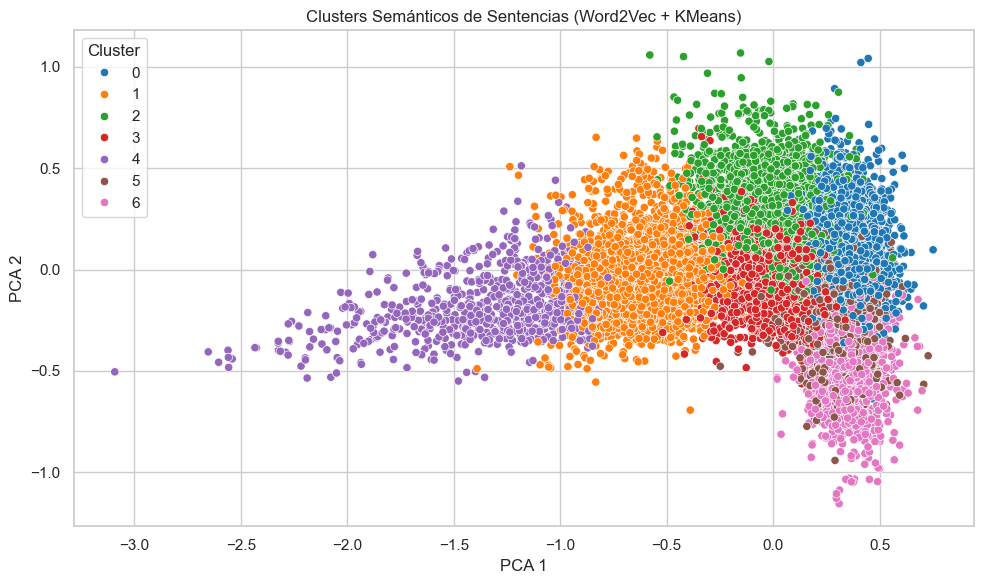


Número de sentencias por cluster:
cluster
0    3561
1    2536
2    3719
3    4086
4     723
5    1947
6    1348
Name: count, dtype: int64


In [218]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Entrenar modelo Word2Vec
w2v_model = Word2Vec(
    sentences=df_cleaned['final_tokens'],
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    seed=42
)

# Función para vectorizar cada documento como promedio de embeddings
def document_vector(doc):
    return np.mean(
        [w2v_model.wv[word] for word in doc if word in w2v_model.wv],
        axis=0
    ) if doc else np.zeros(w2v_model.vector_size)

# Vectorizar todas las sentencias
doc_embeddings = np.array([document_vector(doc) for doc in df_cleaned['final_tokens']])
doc_embeddings = np.nan_to_num(doc_embeddings)  # Eliminar nan

# Reducción PCA para visualización
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(doc_embeddings)

# Clustering con KMeans
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
clusters = kmeans.fit_predict(doc_embeddings)
df_cleaned['cluster'] = clusters

# Visualización en 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=clusters, palette='tab10')
plt.title("Clusters Semánticos de Sentencias (Word2Vec + KMeans)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Mostrar distribución de documentos por cluster
cluster_counts = df_cleaned['cluster'].value_counts().sort_index()
print("\nNúmero de sentencias por cluster:")
print(cluster_counts)


El análisis de agrupamiento semántico basado en Word2Vec y KMeans ha permitido representar las sentencias como vectores en un espacio semántico continuo, revelando patrones de similitud conceptual no evidentes mediante técnicas temáticas tradicionales. A través de la reducción de dimensionalidad con PCA, se identificaron nueve grupos diferenciados, algunos de los cuales presentan una clara cohesión interna, mientras que otros reflejan una mayor diversidad lingüística.

Aunque esta técnica no reemplaza el modelado temático de LDA, ofrece una perspectiva complementaria: mientras LDA identifica tópicos explícitos mediante distribuciones de palabras, el agrupamiento semántico agrupa documentos según proximidad contextual. Esta doble aproximación permite obtener una visión más rica del corpus legal, facilitando futuras tareas de clasificación, recuperación de información o análisis cualitativo orientado a contenidos emergentes.

## 3. Diseño, entrenamiento y evaluación de modelos predictivos

In [205]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Vectorización del texto
documents = [' '.join(tokens) for tokens in df_cleaned['final_tokens']]
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(documents)
y = df_cleaned['case_outcome']

# Separación en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# GridSearch para Logistic Regression (ajustado)
logistic_params = {
    'C': [0.1, 1, 20],
    'solver': ['liblinear']  # liblinear es estable y rápido para multiclase
}
gs_logistic = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000),
    param_grid=logistic_params,
    cv=3,
    scoring='f1_macro',
    verbose=1
)
gs_logistic.fit(X_train, y_train)
print("Best Logistic Params:", gs_logistic.best_params_)
y_pred_logistic = gs_logistic.predict(X_test)
print("\nLogistic Regression:\n", classification_report(y_test, y_pred_logistic))


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Logistic Params: {'C': 20, 'solver': 'liblinear'}

Logistic Regression:
                precision    recall  f1-score   support

     affirmed       0.57      0.76      0.65        21
      applied       0.19      0.20      0.19       404
     approved       0.11      0.11      0.11        18
        cited       0.56      0.48      0.51      1572
   considered       0.24      0.30      0.26       282
    discussed       0.25      0.33      0.28       183
distinguished       0.18      0.23      0.20       101
     followed       0.24      0.29      0.26       343
  referred to       0.34      0.33      0.34       641
      related       0.47      0.42      0.44        19

     accuracy                           0.37      3584
    macro avg       0.31      0.34      0.33      3584
 weighted avg       0.39      0.37      0.38      3584



In [207]:
# GridSearch para Random Forest (acotado para velocidad)
rf_params = {
    'n_estimators': [100, 300],
    'max_depth': [10, 50, None]
}
gs_rf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=rf_params,
    cv=3,
    scoring='f1_macro',
    verbose=1
)
gs_rf.fit(X_train, y_train)
print("Best RF Params:", gs_rf.best_params_)
y_pred_rf = gs_rf.predict(X_test)
print("\nRandom Forest:\n", classification_report(y_test, y_pred_rf))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best RF Params: {'max_depth': 10, 'n_estimators': 300}

Random Forest:
                precision    recall  f1-score   support

     affirmed       0.14      1.00      0.25        21
      applied       0.16      0.12      0.13       404
     approved       0.00      0.00      0.00        18
        cited       0.50      0.38      0.43      1572
   considered       0.21      0.11      0.14       282
    discussed       0.08      0.27      0.12       183
distinguished       0.28      0.21      0.24       101
     followed       0.19      0.22      0.20       343
  referred to       0.26      0.23      0.25       641
      related       0.07      0.37      0.12        19

     accuracy                           0.28      3584
    macro avg       0.19      0.29      0.19      3584
 weighted avg       0.33      0.28      0.29      3584



In [209]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Parámetros para RandomizedSearch
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

# Configuración del modelo y búsqueda
gbc = GradientBoostingClassifier(random_state=42)
rs_gbc = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_dist,
    n_iter=10,  # número total de combinaciones aleatorias
    scoring='f1_macro',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1  # usa todos los núcleos disponibles
)

# Entrenar
rs_gbc.fit(X_train, y_train)
print("Best GBC Params:", rs_gbc.best_params_)

# Evaluar
y_pred_gbc = rs_gbc.predict(X_test)
print("\nGradient Boosting:")
print(classification_report(y_test, y_pred_gbc))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=11029) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=11029) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=11029) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=11029) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarnin

[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, n_estimators=50; total time= 1.3min
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, n_estimators=50; total time= 1.3min
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, n_estimators=50; total time= 1.3min
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, n_estimators=50; total time= 1.3min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, n_estimators=50; total time= 1.3min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, n_estimators=50; total time= 1.3min
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, n_estimators=100; total time= 2.9min
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, n_estimators=100; total time= 2.9min
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, n_estimators=100; total time= 2.9min
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=1, n_estimators=50; total time= 3.5min
[CV] END learning_rate=

In [212]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pandas as pd

# Diccionario para almacenar métricas de cada modelo
results_summary = {
    "Model": [],
    "F1_macro": [],
    "Accuracy": []
}

# Logistic Regression
f1_logistic = f1_score(y_test, y_pred_logistic, average='macro')
acc_logistic = (y_test == y_pred_logistic).mean()
results_summary["Model"].append("Logistic Regression")
results_summary["F1_macro"].append(f1_logistic)
results_summary["Accuracy"].append(acc_logistic)

# Random Forest
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
acc_rf = (y_test == y_pred_rf).mean()
results_summary["Model"].append("Random Forest")
results_summary["F1_macro"].append(f1_rf)
results_summary["Accuracy"].append(acc_rf)

# Gradient Boosting
f1_gbc = f1_score(y_test, y_pred_gbc, average='macro')
acc_gbc = (y_test == y_pred_gbc).mean()
results_summary["Model"].append("Gradient Boosting")
results_summary["F1_macro"].append(f1_gbc)
results_summary["Accuracy"].append(acc_gbc)

# Mostrar resumen comparativo
results_df = pd.DataFrame(results_summary)
print("\nResumen Comparativo de Modelos:")
print(results_df.sort_values("F1_macro", ascending=False))


Resumen Comparativo de Modelos:
                 Model  F1_macro  Accuracy
0  Logistic Regression  0.325972  0.371931
2    Gradient Boosting  0.242695  0.457031
1        Random Forest  0.189170  0.279297
